In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *
import torch
import skimage
import torch.nn.functional as F
from PIL import Image
from fastai.callback.tensorboard import TensorBoardProjectorCallback
import tensorboard as tb

In [2]:
path = Path('/home/yani/Pruebas TFG/DatasetConIncorrectas/Dataset2Arq/Completo/')
dls = ImageDataLoaders.from_folder(path, train='train', valid='valid', bs=9, seed=41)

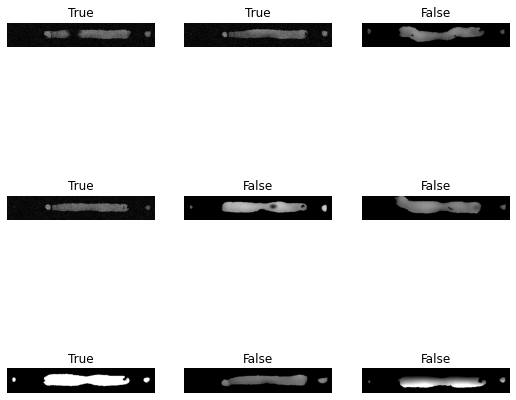

In [3]:
dls.show_batch()

In [4]:
class ModeloSimple(nn.Module):
    def __init__(self):
        super(ModeloSimple, self).__init__()
        # 1 canal de entrada, 6 canales de salida, kernels de 5x5 que
        # se aplican en la convolucion
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # (80/2)/2 - 3 = 17 
        # (480/2)/2 - 3 = 17 
        self.fc1 = nn.Linear(16 * 17 * 117 , 120)  
        self.fc2 = nn.Linear(120, 10)
        # Al tener 2 categorías la última capa debe reducirse a tamaño 2
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        # En este caso el max pooling se hace a traves de una ventana de 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) #Se necesita aplanar el tensor en una dimensión
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
precision = Precision()
F1 = F1Score()

In [10]:
model = ModeloSimple().cuda()
loss_func = nn.CrossEntropyLoss()
learn = Learner(dls, ModeloSimple(), loss_func=loss_func , metrics=[accuracy, precision,F1])
#learn.recorder.after_batch

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.02290867641568184)

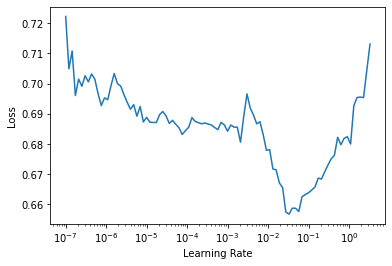

In [11]:
learn.lr_find()

In [12]:
learn.fit(5 , lr=1e-02)

epoch,train_loss,valid_loss,accuracy,precision_score,f1_score,time
0,0.467757,0.424918,0.763699,0.320513,0.345125,00:14
1,0.282258,0.380975,0.787360,0.341880,0.319043,00:14
2,0.251809,0.300623,0.857410,0.570128,0.577491,00:14
3,0.204535,0.241626,0.883562,0.749226,0.564103,00:14
4,0.135226,0.253853,0.891968,0.735000,0.628877,00:15


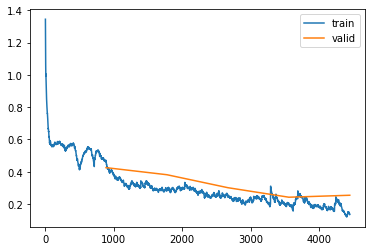

In [13]:
learn.recorder.plot_loss()

In [14]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,precision_score,f1_score,time
0,0.068907,0.295033,0.899751,0.674877,0.718531,00:15


epoch,train_loss,valid_loss,accuracy,precision_score,f1_score,time
0,0.071201,0.275354,0.901930,0.700730,0.709141,00:15
1,0.055140,0.317369,0.896949,0.654079,0.723475,00:16
2,0.032290,0.293445,0.909091,0.717352,0.733090,00:15
3,0.026392,0.309668,0.907534,0.708042,0.731707,00:15


In [20]:
learn.model

ModeloSimple(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=31824, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

In [14]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop
   - after_

In [31]:
import torch.utils.tensorboard
import torchvision
import torchvision.transforms as transforms
imagenes = torchvision.datasets.ImageFolder(root='/home/yani/Pruebas TFG/DatasetConIncorrectas/Dataset2Arq/Completo/valid', transform=transforms.PILToTensor())
transform=transforms.PILToTensor()

imagenes = get_image_files(path)
imagen = Image.open('/home/yani/Pruebas TFG/DatasetConIncorrectas/Dataset2Arq/Completo/valid/True/Dia_1_Pieza_1_Soldadura_78_H.png').convert('RGB')

imagen = transform(imagen)

imagen = imagen.unsqueeze(0)
imagen = imagen.float()
imagen = imagen.cuda()

writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir='./runs/final')
writer.add_graph(model,imagen)